In [53]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from keras import metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.metrics import confusion_matrix
import nltk

In [54]:

# Load the dataset
data = pd.read_csv("news.csv")


In [55]:
analyzer = SentimentIntensityAnalyzer()

# Add a new column to the dataset with the sentiment scores
data["sentiment"] = data["headline"].apply(lambda x: "positive" if analyzer.polarity_scores(x)["compound"] >= 0.05 else ("negative" if analyzer.polarity_scores(x)["compound"] <= -0.05 else "neutral"))
X = data['headline']
Y = data['sentiment']


In [56]:
data

,headline,Timestamp,Section,headlines cover,sentiment
0,After the special court's verdict in the high ...,"01 Jan, 2020 09:55pm",NaN,Federation of Pakistan v Gen Pervez Musharraf:...,negative
1,The suspect assaulted the constable after he p...,"01 Jan, 2020 08:35pm",Pakistan,Chinese national held for beating traffic poli...,negative
2,"Overnight, demonstrators pitched tents and cam...","01 Jan, 2020 07:26pm",World,Iraqi paramilitaries call for withdrawal from ...,neutral
3,We also have a release date.,"02 Jan, 2020 01:17pm",Pakistan,Sarmad Khoosat reveals why Zindagi Tamasha's t...,neutral
4,"Of the total 34 matches, 14 will take place in...","02 Jan, 2020 10:56am",Sport,PSL 2020 set to begin on February 20,neutral
...,...,...,...,...,...
26701,Pakistan welcomes renewed US push for Afghan p...,“We welcome the US efforts to re-energise the ...,"11 Mar, 2021 07:02am",Newspaper,positive
26702,"Myanmar junta spurns UN appeal, kills more pr...",The military has also lodged a new allegation ...,"11 Mar, 2021 07:02am",Newspaper,negative
26703,Remittances jump by 24pc to $18.7bn in 8MFY21,"If June FY20 is also counted, it is the ninth ...","11 Mar, 2021 07:02am",Newspaper,neutral
26704,Pakistan blocks TikTok after ban by PHC,Company running app say it is maintaining a sa...,"11 Mar, 2021 07:02am",Pakistan,negative


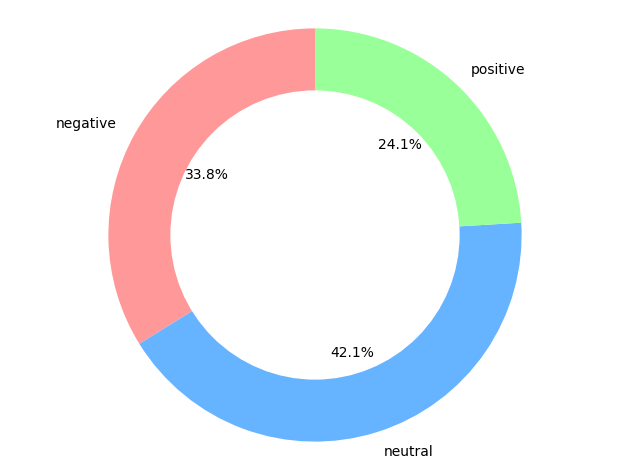

In [57]:
# Count the number of occurrences of each label
label_counts = {}
for label in Y:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Create a pie chart of the label counts
labels = list(label_counts.keys())
sizes = [label_counts[label] for label in labels]
colors = ['#ff9999','#66b3ff','#99ff99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()


In [58]:

le = LabelEncoder()

# Fit and transform the labels
Y = le.fit_transform(Y)
Y = to_categorical(Y)

#### We will create a function for pre-processing of data
1. First, we will iterate through each record and using regualr expression, we will get rid of any characters apart from alphabets.
2. Then, we will convert the string to lowercase as, the word "Good" is different from the word "good". This will cause an issue, when we will create vectors of these words, as two different vectors will be created for the same word which we don't want to.
3. Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as "the","an","to" etc. which do not add much value.
4. Then, we will perform lemmatization on each word,i.e. change the different forms of word into a single item called as lemma. A lemma is a base form of a word. For example, run, running and runs are all forms of same lexeme where run is the lemma. Hence, we are converting all occurrences of same lexeme to it's respective lemma.
5. And, then return a corpus of processed data

In [59]:
def pre_processing_text(df_col):
    #object of WordNetLemmatizer
    lm = WordNetLemmatizer()
    corpus = []
    for item in df_col:
        new_item = re.sub(r'[^a-zA-Z\s]','',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        new_item = [x for x in new_item if x!='u' if x!='say']
        corpus.append(' '.join(str(x) for x in new_item))

    
    return corpus


def tokenization_text(data):
            # Tokenize the text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    vocab_size = len(tokenizer.word_index) + 1

    # Pad the sequences to a fixed length
    max_length = max([len(s.split()) for s in data])
    X = pad_sequences(tokenizer.texts_to_sequences(data), padding='post', maxlen=max_length)
    
    return X, vocab_size, tokenizer, max_length

In [60]:
X = pre_processing_text(X)

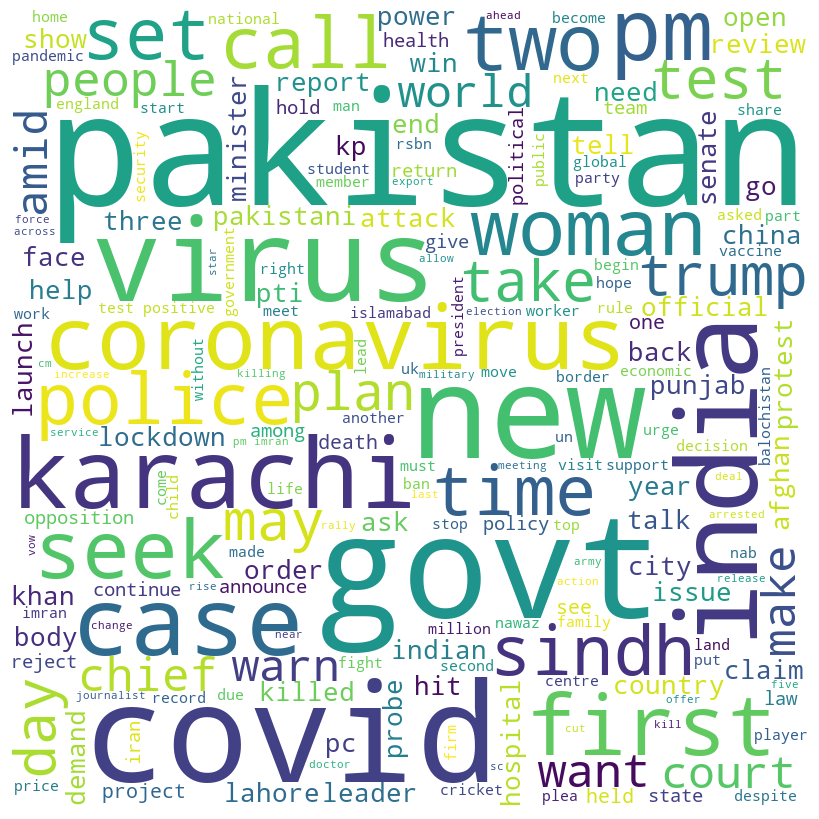

In [61]:

word_cloud = ""
for row in X:
    for word in row:
        word_cloud+=" ".join(word)


# Create a word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(word_cloud)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\umair\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


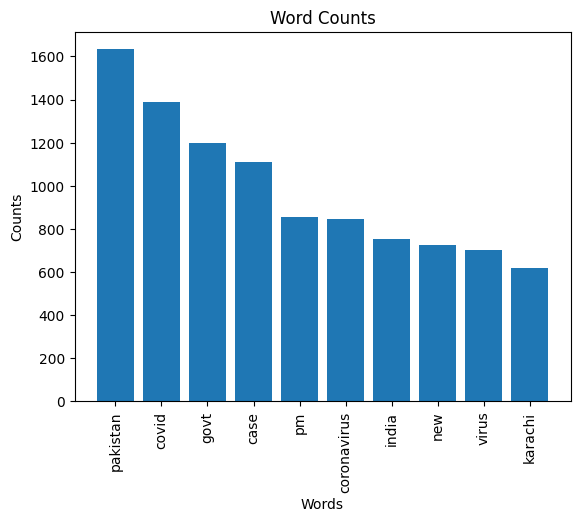

In [62]:

nltk.download('punkt')


# Tokenize the text data
all_text = ' '.join(X)
tokens = nltk.word_tokenize(all_text)

# Perform word counting
fdist = FreqDist(tokens)

# Get the 10 most common words
common_words = fdist.most_common(10)

# Extract the words and counts into separate lists
words = [word for word, count in common_words]
counts = [count for word, count in common_words]

# Create a bar chart of the common words
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Counts')
plt.xticks(rotation=90)
plt.show()


In [63]:
X, vocab_size, tokenizer, max_length = tokenization_text(X)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [65]:
# Load pre-trained embeddings
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [66]:
# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [67]:
# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))


In [68]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20
676/676 [==============================] - 14s 20ms/step - loss: 0.3662 - accuracy: 0.8632 - val_loss: 0.4998 - val_accuracy: 0.8153
Epoch 2/20
676/676 [==============================] - 15s 22ms/step - loss: 0.3587 - accuracy: 0.8654 - val_loss: 0.4936 - val_accuracy: 0.8195
Epoch 3/20
676/676 [==============================] - 14s 20ms/step - loss: 0.3524 - accuracy: 0.8677 - val_loss: 0.4769 - val_accuracy: 0.8315
Epoch 4/20
676/676 [==============================] - 14s 21ms/step - loss: 0.3502 - accuracy: 0.8675 - val_loss: 0.4705 - val_accuracy: 0.8315
Epoch 5/20
676/676 [==============================] - 14s 21ms/step - loss: 0.3429 - accuracy: 0.8719 - val_loss: 0.4749 - val_accuracy: 0.8270
Epoch 6/20
676/676 [==============================] - 14s 21ms/step - loss: 0.3325 - accuracy: 0.8743 - val_loss: 0.4661 - val_accuracy: 0.8415
Epoch 7/20
676/676 [==============================] - 14s 20ms/step - loss: 0.3274 - accuracy: 0.8782 - val_loss: 0.4850 - val_accuracy:

In [70]:
# Evaluate the model on the test data
score, acc = model.evaluate(X_test, y_test, batch_size=32)
print('Test score:', acc)

84/84 [==============================] - 0s 5ms/step - loss: 0.5236 - accuracy: 0.8169
Test score: 0.8169224858283997


In [75]:

# Make predictions on the test data
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Print the predicted class labels
print(y_pred)


84/84 [==============================] - 0s 4ms/step
[1 1 0 ... 1 2 2]


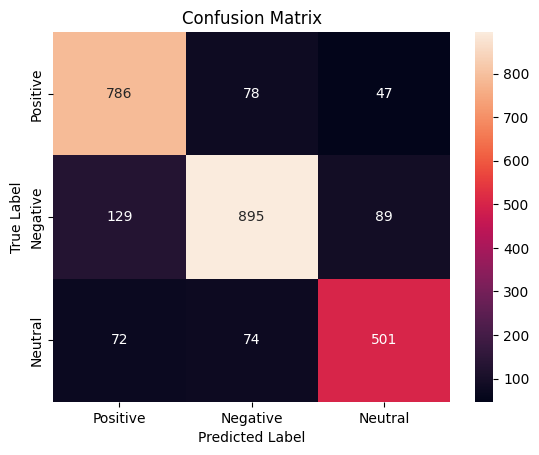

In [72]:


# Get the confusion matrix
y_test = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(conf_matrix, xticklabels=["Positive", "Negative", "Neutral"], yticklabels=["Positive", "Negative", "Neutral"], annot=True, fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


|               |Predicted Positive  |Predicted Negative  |Predicted Neutral |
|----------------|-------------|-------------|-------------|
|Actual Positive        | TP          | FN          | FN2         |
|----------------|-------------|-------------|-------------|
|Actual Negative        | FP          | TN          | FN3        |
|----------------|-------------|-------------|-------------|
|Actual Neutral        | FP2         | FN4          | TN2        |


* The value in the first column of the first row represents the number of samples that were predicted to be "positive" and are actually "positive". This is the True Positive (TP).
* The value in the second column of the first row represents the number of samples that were predicted to be "negative" but are actually "positive". This is the False Negative (FN).
* The value in the third column of the first row represents the number of samples that were predicted to be "neutral" but are actually "positive". This is the False Negative (FN2).
* The value in the first column of the second row represents the number of samples that were predicted to be "positive" but are actually "negative". This is the False Positive (FP).
* The value in the second column of the second row represents the number of samples that were predicted to be "negative" and are actually "negative". This is the True Negative (TN).
* The value in the third column of the second row represents the number of samples that were predicted to be "neutral" but are actually "negative". This is the False Negative (FN3).
* The value in the first column of the third row represents the number of samples that were predicted to be "positive" but are actually "neutral". This is the False Positive (FP2).
* The value in the second column of the third row represents the number of samples that were predicted to be "negative" but are actually "neutral". This is the False Negative (FN4).
* The value in the third column of the third row represents the number of samples that were predicted to be "neutral" and are actually "neutral". This is the True Negative (TN2).

In [76]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Neutral Sentiment.")
    elif prediction_input == 2:
        print("Input statement has Positive Sentiment.")    
    else:
        print("Invalid Statement.")
        
def sentiment_predictor(model, X):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    return expression_check(y_pred)

In [84]:
input1 = ["Russia stops oil supplies to Belarus"]

X = pre_processing_text(input1)
X = tokenization_text(X)

sentiment_predictor(model, X[0])

1/1 [==============================] - 0s 27ms/step
Input statement has Neutral Sentiment.


Accuracy of our model on test data :  81.69224858283997 %


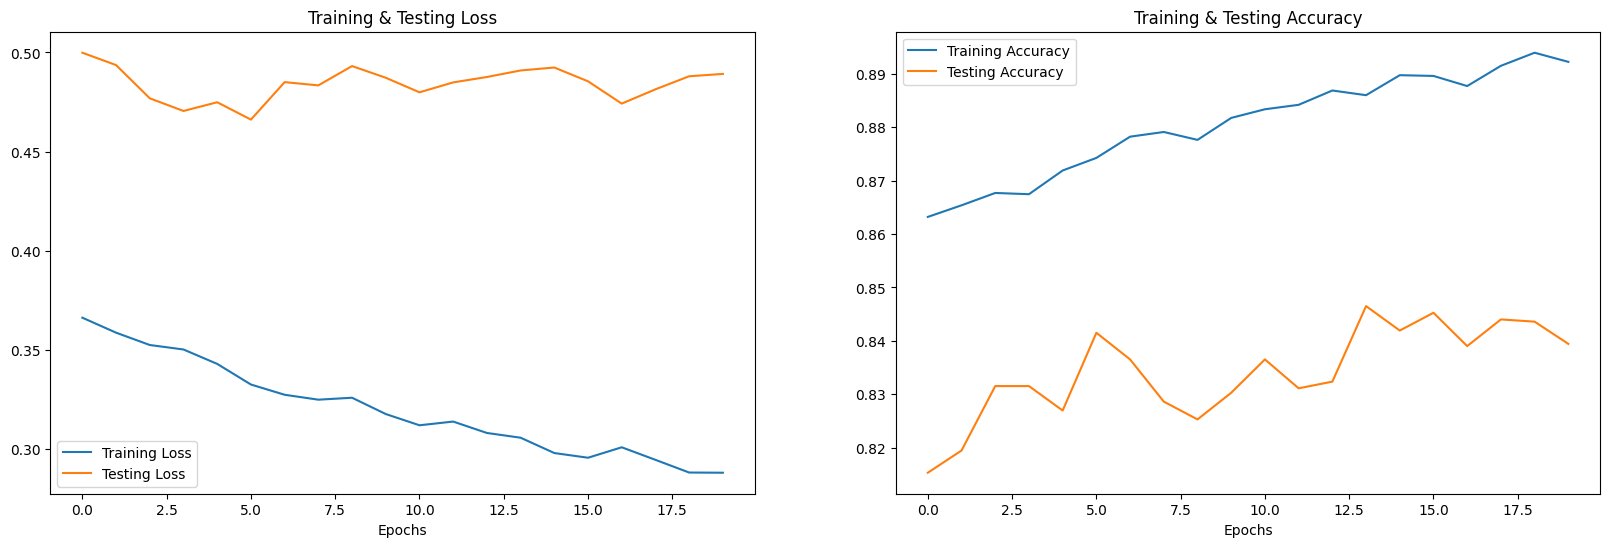

In [96]:
print("Accuracy of our model on test data : ", acc*100 , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()